In [1]:
%reload_ext watermark

In [2]:
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.10.0

numpy      : 1.24.2
pandas     : 1.5.3
pycocotools: 2.0.6
torch      : 1.13.1+cu116
torchvision: 0.14.1+cu116
detectron2 : 0.6



In [3]:
from detectron2.utils.logger import setup_logger
import os
import numpy as np
import cv2
import pandas as pd
from detectron2 import model_zoo
import data_prep
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from data_prep import get_data_records
import torch, torchvision
from abc import ABC
setup_logger()

<Logger detectron2 (DEBUG)>

#### Configurations

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 4, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### Read the Dataset into a DataFrame Object

In [5]:

train_data = get_data_records(split='train')
test_data = get_data_records(split='test')
val_data = get_data_records(split='val')
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)
val_data_df = pd.DataFrame(val_data)
train_data_df.head(10)

Generating Dataset Records:   0%|          | 0/1708 [00:00<?, ?it/s]

Generating Dataset Records:   0%|          | 0/569 [00:00<?, ?it/s]

Generating Dataset Records:   0%|          | 0/570 [00:00<?, ?it/s]

,file_name,image_id,height,width,class_name,annotations
0,data\2002\08\11\big\img_591.jpg,0,431,450,face,"[{'bbox': [184, 38, 354, 284], 'category_id': ..."
1,data\2002\08\26\big\img_265.jpg,1,305,449,face,"[{'bbox': [61, 20, 149, 154], 'category_id': 0..."
2,data\2002\07\19\big\img_423.jpg,2,450,449,face,"[{'bbox': [196, 46, 314, 220], 'category_id': ..."
3,data\2002\08\24\big\img_490.jpg,3,450,370,face,"[{'bbox': [110, 24, 180, 132], 'category_id': ..."
4,data\2002\08\31\big\img_17676.jpg,4,450,364,face,"[{'bbox': [-1, 0, 57, 74], 'category_id': 0, '..."
5,data\2002\07\31\big\img_228.jpg,5,450,409,face,"[{'bbox': [70, 52, 136, 162], 'category_id': 0..."
6,data\2002\07\24\big\img_402.jpg,6,311,450,face,"[{'bbox': [328, 31, 366, 81], 'category_id': 0..."
7,data\2002\08\04\big\img_769.jpg,7,450,318,face,"[{'bbox': [22, 7, 150, 211], 'category_id': 0,..."
8,data\2002\07\19\big\img_581.jpg,8,450,317,face,"[{'bbox': [85, 86, 225, 292], 'category_id': 0..."
9,data\2002\08\13\big\img_723.jpg,9,449,348,face,"[{'bbox': [82, 57, 260, 297], 'category_id': 0..."


##### Image Annotations (Printing the bounding box of the Face)

In [6]:
def annotate_images(data_point: pd.Series):
    image = plt.imread(data_point.loc['file_name'])
    for anno in data_point['annotations']:
        upper_left_corner = tuple(anno['bbox'][:2])
        bottom_right_corner = tuple(anno['bbox'][2:])
        cv2.rectangle(image, upper_left_corner, bottom_right_corner, (0, 255, 0), 2)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    return image

##### Visualising a Random Subset of The Dataset

C:\Users\Ali-Abbas\AppData\Local\Temp\ipykernel_12332\1826141948.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sample_images = torch.as_tensor(sample_images)


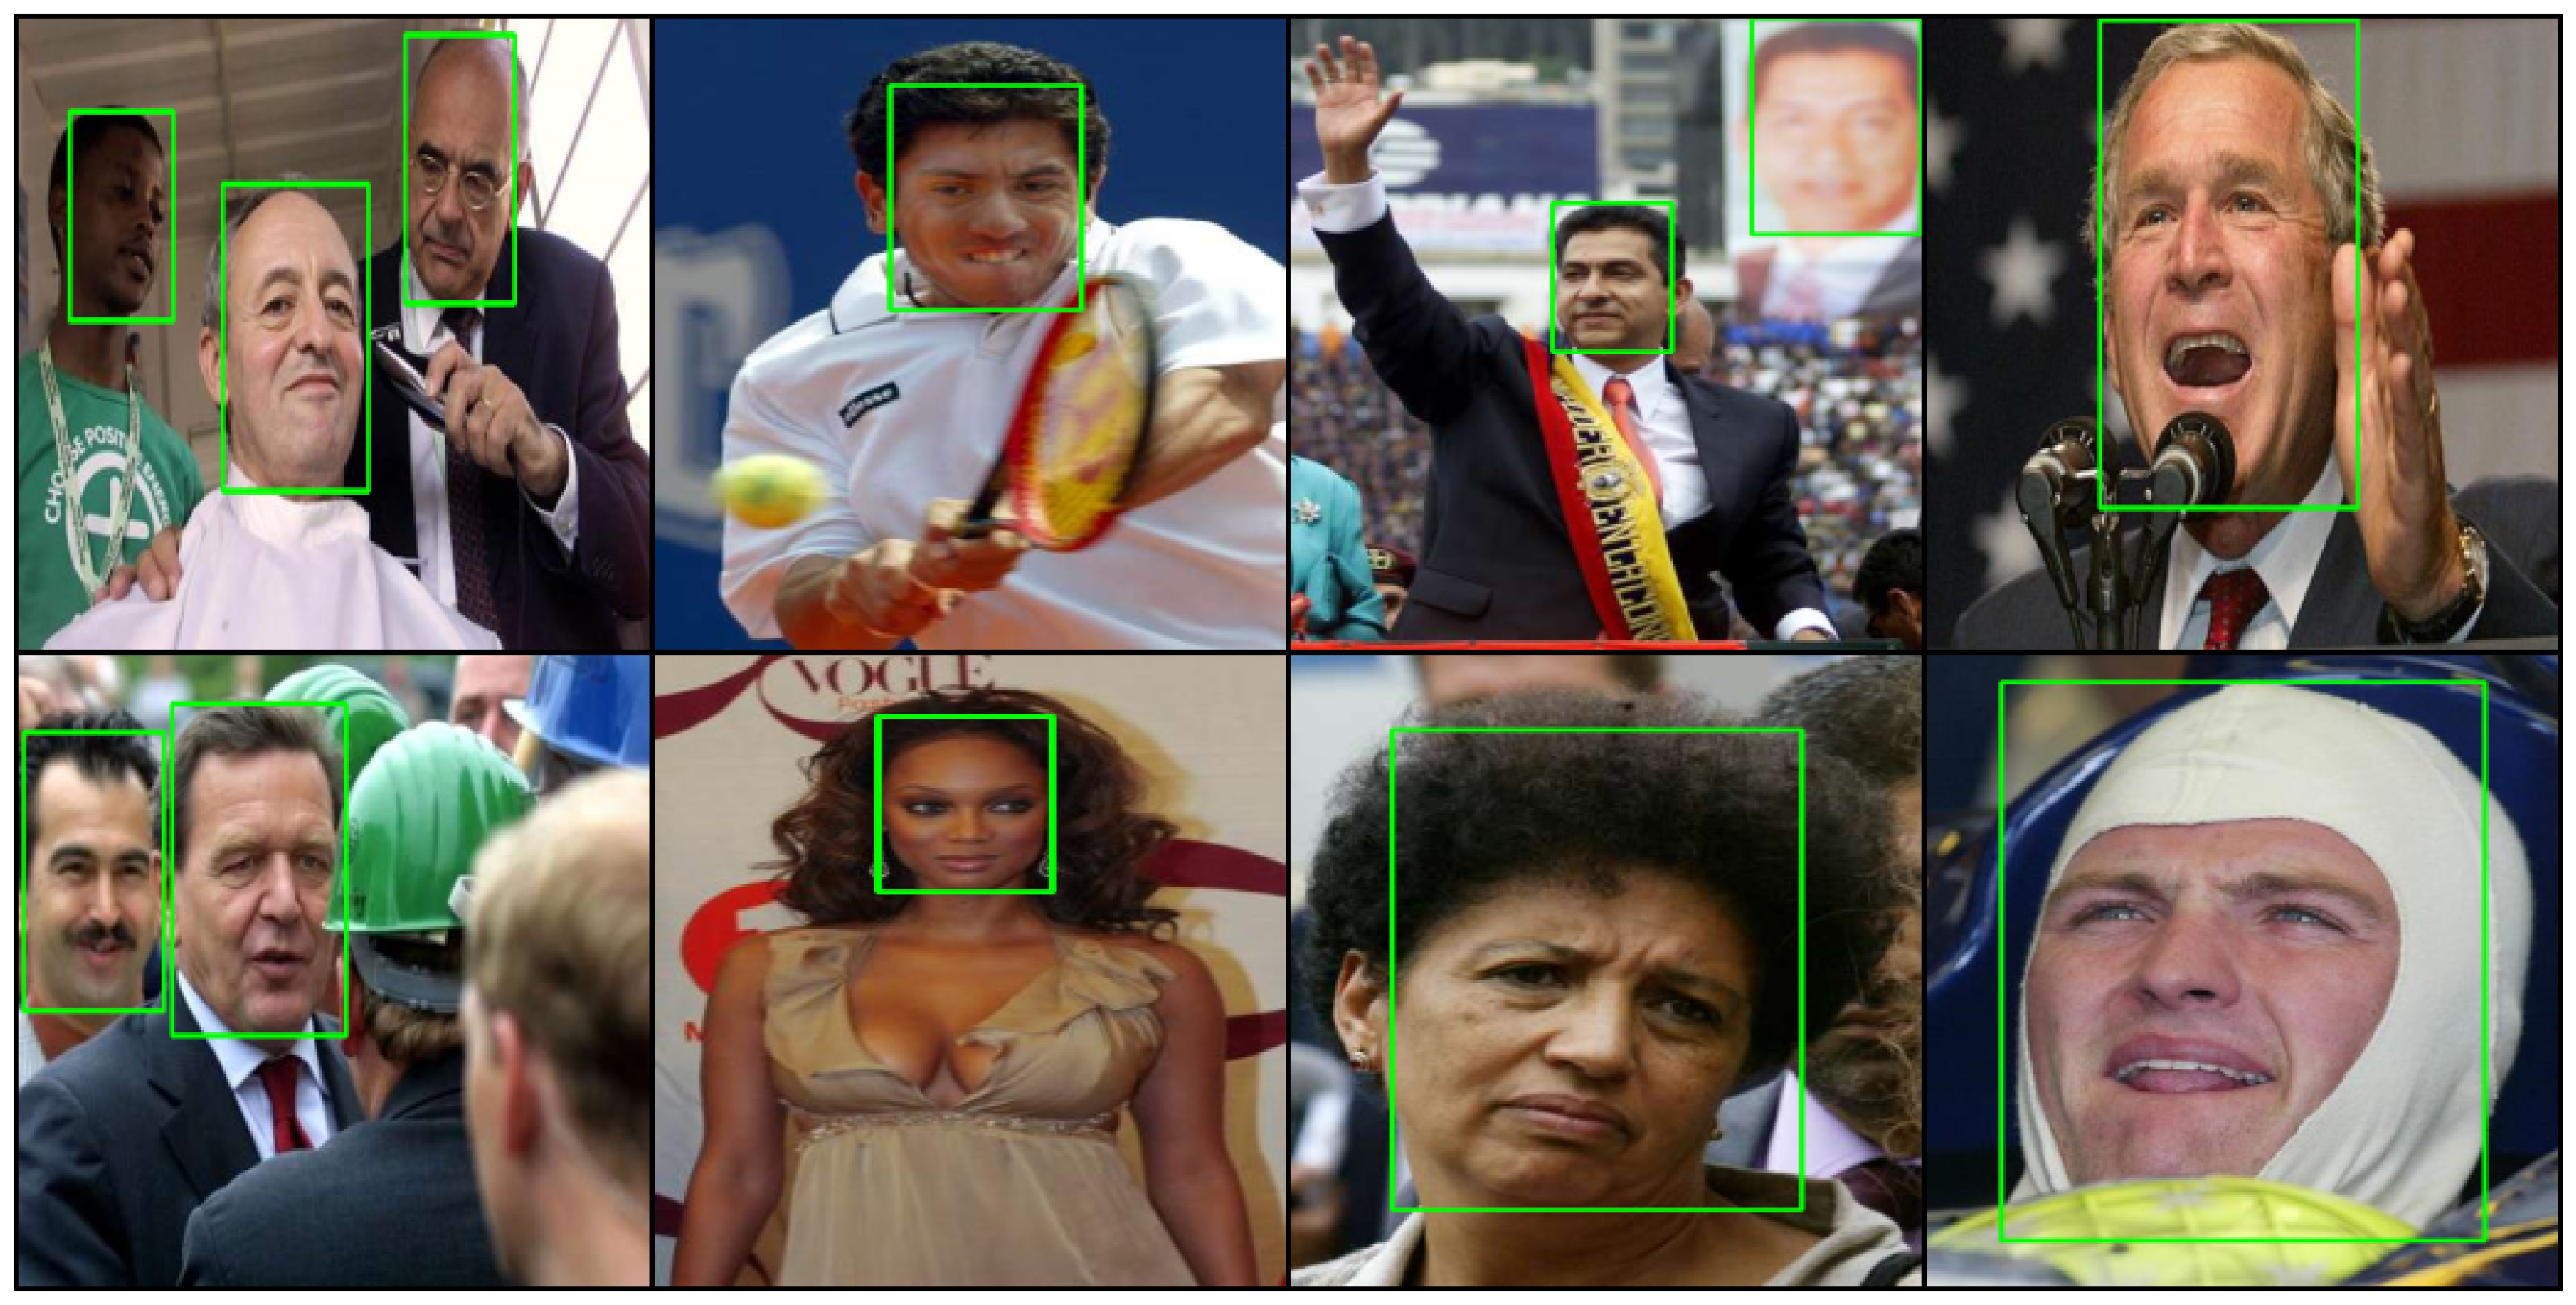

In [7]:
indexes = np.random.randint(low=0, high=train_data_df.shape[0], size=(8,)).astype(int)
sample_images = [annotate_images(data_point) for _, data_point in train_data_df.iloc[indexes].iterrows()]
sample_images = torch.as_tensor(sample_images)
sample_images = sample_images.permute(0, 3, 1, 2)
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators
from detectron2.config import get_cfg
from tqdm.auto import tqdm
from detectron2.model_zoo import model_zoo
class MyTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)


    def run_step(self):
        loss_dict = self.model(self.data_dict)
        losses = sum(loss_dict.values())
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()

    def train(self):
        for epoch in tqdm(range(self.start_epoch, self.max_epoch)):
            self.scheduler.step()
            self.storage.put_scalar("lr", self.optimizer.param_groups[0]["lr"], smoothing_hint=False)
            for data_dict in tqdm(self.data_loader):
                self.data_dict = data_dict
                self.run_step()

            if self.cfg.TEST.EVAL_PERIOD > 0 and epoch % self.cfg.TEST.EVAL_PERIOD == 0:
                self.run_test()

            if self.checkpointer.should_save(epoch):
                self.checkpointer.save(epoch)
    def build_evaluator(self, cfg, dataset_name: str='FDDB_val', output_folder=None):
        if output_folder is None:
            os.makedirs('coco_eval', exist_ok=True)
            output_folder = 'coco_eval'
        return COCOEvaluator(dataset_name=dataset_name, output_dir=output_folder)

In [12]:
def train_and_evaluate_model(model_name):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.DATASETS.TRAIN = ("FDDB_train",)
    cfg.DATASETS.TEST = ("FDDB_val",)
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 10_000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.EVAL_PERIOD = 500
    output_dir = os.path.join('output', model_name)
    os.makedirs(output_dir, exist_ok=True)
    cfg.OUTPUT_DIR = output_dir
    # Train the model.
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()


In [13]:
networks = ['COCO-Detection/retinanet_R_50_FPN_1x.yaml',
            'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
            'COCO-Detection/retinanet_R_101_FPN_3x.yaml',
            'COCO-Detection/rpn_R_50_C4_1x.yaml',
            'COCO-Detection/rpn_R_50_FPN_1x.yaml', ]
try:
    data_prep.register()
except AssertionError:
    pass

metrics = {}

for network in networks:
    train_and_evaluate_model(model_name=network)

Loading config c:\users\ali-abbas\detectron2\detectron2\model_zoo\configs\COCO-Detection\../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[03/05 17:20:35 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Generating Dataset Records:   0%|          | 0/1708 [00:00<?, ?it/s]

[03/05 17:20:37 d2.data.build]: Removed 0 images with no usable annotations. 1708 images left.
[03/05 17:20:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/05 17:20:37 d2.data.build]: Using training sampler TrainingSampler
[03/05 17:20:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/05 17:20:37 d2.data.common]: Serializing 1708 elements to byte tensors and concatenating them all ...
[03/05 17:20:37 d2.data.common]: Serialized dataset takes 0.54 MiB
WARNING [03/05 17:20:37 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[03/05 17:20:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


AttributeError: 'MyTrainer' object has no attribute 'max_epoch'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir coco_eval